## Read and prepare data

In [1]:
import matplotlib
import cv2
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pathlib

Using TensorFlow backend.


In [2]:
data = []
labels = []

#берём пути к изображениям и рандомно перемешиваем
data_root = pathlib.Path("C:\\UIR\\samples\\sample_1\\1000\\cut_letters")
imagePaths = list(data_root.glob('*/*'))
imagePaths = [str(path) for path in imagePaths]
random.shuffle(imagePaths)

#цикл по изображениям
for imagePath in imagePaths:
    #загружаем изображение, меняем размер на 28x28 пикселей и добавляем в список
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(28,28))
    data.append(image)
    
    #извлекаем метку класса из пути к изображению и обновляем список меток
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [3]:
data[0].shape

(28, 28, 3)

In [4]:
# масштабируем интенсивности пикселей из диапазона [0,255] -> в диапазон [0, 1]
data = np.array(data,dtype="float") / 255.0
labels = np.array(labels)

In [5]:
# разбиваем данные на обучающую и тестовую выборки, используя 75% 
# данных для обучения и оставшиеся 25% для тестирования
(trainX,testX, trainY,testY) = train_test_split(data, labels, test_size = 0.25, random_state = 42)

In [8]:
print(testX.shape)
print(trainX.shape)

(9100, 28, 28, 3)
(27300, 28, 28, 3)


In [9]:
#Конвертируем метки из целых чисел в векторы
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY) #находит все уникальные метки класса в testY, а затем преобразует их в метки One-Hot Encoding
testY = lb.transform(testY) #выполняет один шаг One-Hot Encoding исходя из найденных уникальных меток на предыдущем шаге

In [10]:
print('X_train shape:', trainX.shape)
print(trainX.shape[0], 'train samples')
print(testX.shape[0], 'test samples')

X_train shape: (27300, 28, 28, 3)
27300 train samples
9100 test samples


## CNN Architecture

In [14]:
EPOCHS = 20
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 3) #input_shape будет равен 28x28x3
num_classes = 28


model = Sequential()
model.add(Conv2D(filters=50,kernel_size=(5, 5),strides=(1, 1), activation='sigmoid', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))
model.add(Conv2D(filters=100,kernel_size=(5, 5),strides=(1, 1), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Flatten())
model.add(Dense(300, activation='sigmoid'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#Компилируем модель, используя adadelta как оптимизатор и категориальную
# кросс-энтропию в качестве функции потерь. Добавляем метрики
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [15]:
#отобразим получившуюся модель
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 50)        3800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 100)         125100    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 100)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               480300    
_________________________________________________________________
dense_2 (Dense)              (None, 28)               

In [27]:
from keras import callbacks

In [28]:
#подключаем колбаски для работы tensorboard
#write tensorboard --logdir C:/UIR/network_02/logs in cmd

from keras import callbacks
checkpoint_filepath = 'C:\\UIR\\network_02\\checkpoints'

my_callbacks = [
    # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
    callbacks.EarlyStopping(monitor='val_loss', patience=3), #возможно val_loss -> loss
    #tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_acc',mode='max',save_best_only=True),
    callbacks.TensorBoard(log_dir="C:\\UIR\\network_02\\logs", histogram_freq = 1, write_graph = True, write_grads = True,write_images = True)
]
# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

In [29]:
H = model.fit(trainX, trainY, verbose=2, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32, callbacks=my_callbacks)

Train on 27300 samples, validate on 9100 samples
Epoch 1/20
 - 39s - loss: 0.6534 - accuracy: 0.8313 - val_loss: 0.0376 - val_accuracy: 0.9931
Epoch 2/20
 - 41s - loss: 0.0252 - accuracy: 0.9947 - val_loss: 0.0157 - val_accuracy: 0.9978
Epoch 3/20
 - 39s - loss: 0.0140 - accuracy: 0.9974 - val_loss: 0.0113 - val_accuracy: 0.9977
Epoch 4/20
 - 38s - loss: 0.0106 - accuracy: 0.9980 - val_loss: 0.0101 - val_accuracy: 0.9980
Epoch 5/20
 - 41s - loss: 0.0080 - accuracy: 0.9984 - val_loss: 0.0086 - val_accuracy: 0.9985
Epoch 6/20
 - 42s - loss: 0.0067 - accuracy: 0.9987 - val_loss: 0.0083 - val_accuracy: 0.9986
Epoch 7/20
 - 42s - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0074 - val_accuracy: 0.9988
Epoch 8/20
 - 38s - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0080 - val_accuracy: 0.9986
Epoch 9/20
 - 37s - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0076 - val_accuracy: 0.9988
Epoch 10/20
 - 36s - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0070 - val_accuracy: 0.9990
Epoch 11/2

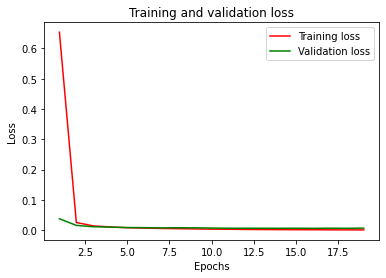

In [31]:
#plotting training and validation loss
import matplotlib.pyplot as plt
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

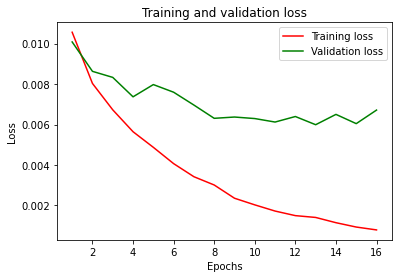

In [58]:
#plotting training and validation loss
import matplotlib.pyplot as plt
loss = H.history['loss']
loss = loss[3:]
val_loss = H.history['val_loss']
val_loss = val_loss[3:]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

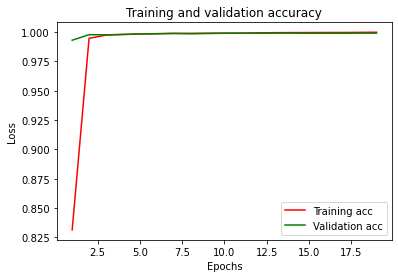

In [36]:
#plotting training and validation accuracy
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

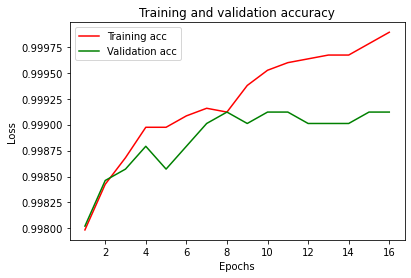

In [62]:
#plotting training and validation accuracy
acc = H.history['accuracy']
acc = acc[3:]
val_acc = H.history['val_accuracy']
val_acc = val_acc[3:]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(trainX[10].reshape(1,28,28,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
        

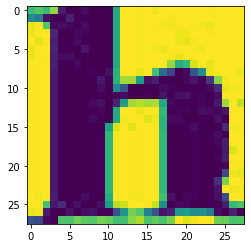

In [65]:
plt.imshow(trainX[10][:,:,0]);

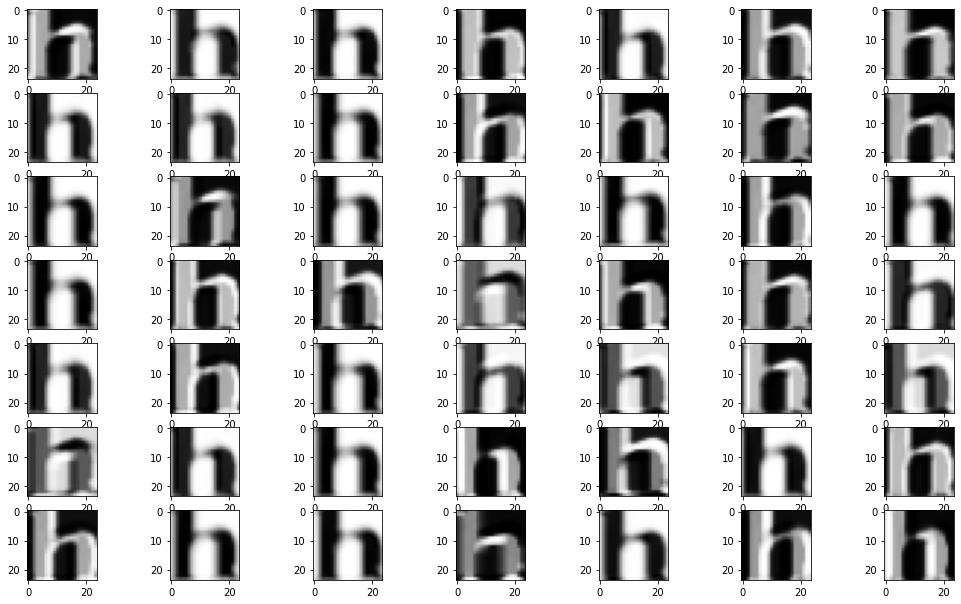

In [59]:
display_activation(activations, 7, 7, 0) #Desplaying above image after layer 1

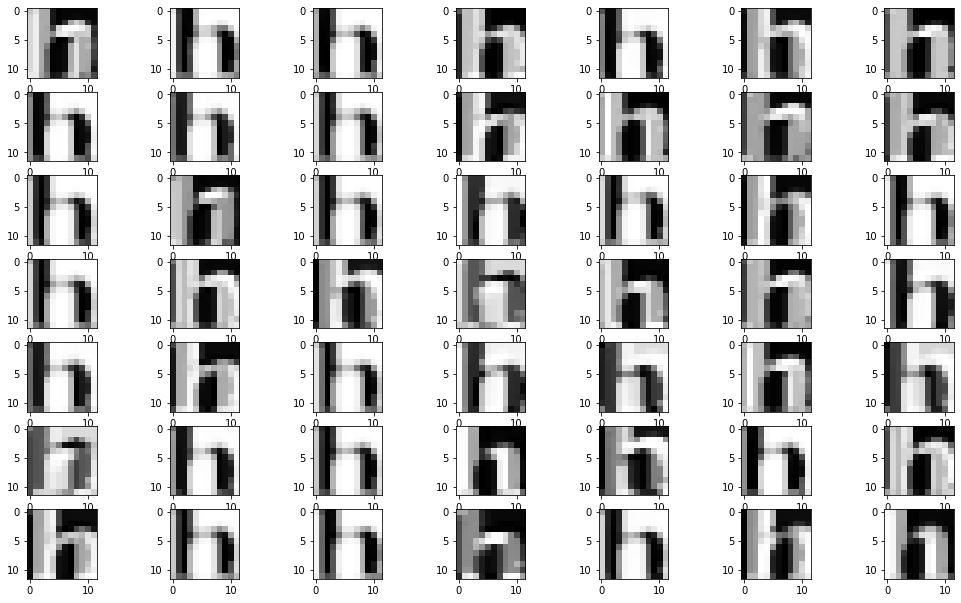

In [48]:
display_activation(activations, 7, 7, 1) #Desplaying above image after layer 2 

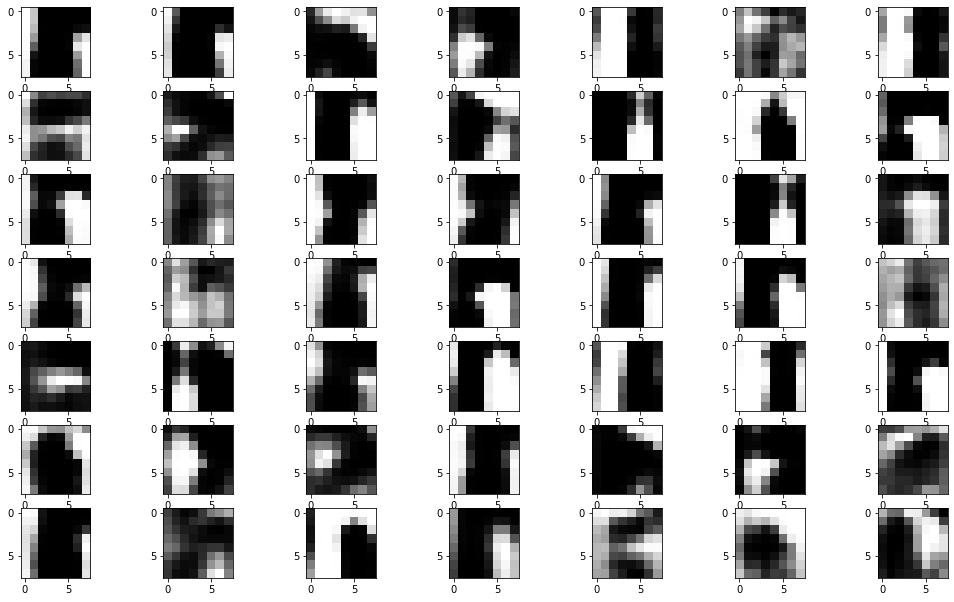

In [66]:
display_activation(activations, 7, 7, 2) #Desplaying above image after layer 3 

In [40]:
trainX[10].shape

(28, 28, 3)

In [30]:
model.save('model_02.h5')
f = open("C:\\UIR\\network_02\\bin_class.txt", "wb")
f.write(pickle.dumps(lb))
f.close()

In [ ]:
#loss, acc = model.evaluate(testX,  testY, verbose=2)
#print("Точность восстановленной модели: {:5.2f}%".format(100*acc))